# Dimension adaptive sampling tutorial

Here, briefly describe the concept behind dimension-adaptive sparse grids, starting from a standard Stochastic Collocation (SC) campaign. Following this, a dimension adaptive EasyVVUQ script using a simple analytic test function is presented. We will assume you are familiar with the basics of EasyVVUQ.

## Standard SC

In a standard EasyVVUQ Campaign, a Stochastic Collocation sampler object might be created via::

```python
sampler = uq.sampling.SCSampler(vary=vary, polynomial_order=2)
```
Here the specified `polynomial_order`, and the number of inputs in `vary`, determine the
number of samples, which increases exponentially fast with an increasing amount of inputs. This
is the so-called *curse of dimensionality*. 

Basically, by setting `polynomial_order=2` we create a sampling plan through a single tensor product of one-dimensional quadrature nodes with order 3 for every input. It is this tensor product construction that leads to the exponential rise in cost. So if we have 2 inputs `x1` and `x2`, and our one-dimensional quadrature rule of order 2 produces 5 points, we obtain a total of 25 points in the `(x1, x2)` domain. Likewise, if `vary` contains 3 inputs, we would need to evaluate the computational model 125 times, and 10 inputs would require `5**10 = 9765625` model evaluations. For this reason, a standard SC campaign is rarely used beyond 6 or 7 inputs.

## Sparse SC

Sparse grids on the other hand, do not create a single tensor product, but build the sampling plan from the ground up by using a *linear combination of tensor products involving 1D quadrature rules of* ***different*** *orders*. 

For two inputs, we might for instance consider using 1D quadrature rules of order [0, 0], [0, 1] and [1, 0], where:

    * [0, 0]: a single point in the 2D domain (x1, x2)
    * [0, 1]: a line of 3 points with constant x1
    * [1, 0]: a line of 3 points with constant x2

In the case of sparse grids it is common to select a *nested* quadrature rule. This means that the quadrature
rule of order p contains all points of the same rule of order p-1. When taking the linear combinations, a nested rule ensures that many points will conincide, which yields efficient sampling 
plans, especially in higher dimensions. If our nested 1D rule of order 1 and 2 generates the points [0.5] and [0, 0.5, 1] we obtain a sampling plan consisting of

    * [0, 0]: [0.5, 0.5]
    * [0, 1]: [0.5, 0.0], [0.5, 0.5], [0.5, 1.0]
    * [1, 0]: [0.0, 0.5], [0.5, 0.5], [1.0, 0.5],

which gives a total of 5 unique points, compared to a corresponding standard SC campaign with [1, 1], which would generate 9 unique points (`[0, 0.5, 1] x [0, 0.5, 1.0]`). Note that sparse grids do **not** circumvent the curse of dimensionality, although they can postpone its effect to higher dimensions.

## Dimension-adaptive SC

What we described above is an *isotropic* sparse grid, since the multi indices `[0, 0], [1, 0], [0,1]` result in a sampling plan where both inputs end up with the same number of samples. However, in practice model parameters are rarely equally important. The idea behind dimension-adaptive sampling is to build the sampling plan in an iterative fashion, find out which (combination of) parameters are important as we go, and then place more samples along those directions. This results in a anisotropic sampling plan, where the important inputs get relatively high number of samples. To find out which directions are important we need an appropriate error measure, and we need to split the quadrature order multi indices in an *accepted* and an *admissible* set. The accepted set is initialized to `[0, 0]` in 2D, i.e. we start with just a single code evaluation. Without going into detail, we can think of the admissible set as the candidate refinement directions, from which we must add a single entry to the accepted set at every iteration.

In our 2D example, at the 1st iteration the candidate set consists of `[1, 0]` and `[0, 1]`. That is, we can either refine only `x1` or only `x2`. We must select the multi index which generates the highest error when added to the accepted set. There are a variety of error measures, the two main ones in EasyVVUQ are:

1. the hierarchical surplus error, and
2. a variance-based error.

Roughly speaking, the surplus is an interpolation based error, which measures the difference between the code output and the corresponding SC polynomial surrogate, when evaluated at new sample locations. The variance-based error selects the direction in which the variance in the output changes the most. For more information we refer to the references below.

Assume that `[1, 0]` generated the highest error, and so it is added to the accepted set, now consisting of `[0, 0]` and `[1, 0]`. This means that `x1` has more points than `x2`. Also, adding a multi index to the accepted set means that the admissible set changes. In this case, since `[1, 0]` has been accepted, `[2, 0]` has become admissible. Note that the new entry `[2, 0]` also requires new evaluations of the code, and so a new ensemble must be submitted. Again, if we use a nested rule, the grid of `[2, 0]` will have a partial overlap with the accepted points, so we only have to evaluate the code at the new points, *not* all points of `[2, 0]`.

Thus, the admissible set now consists of `[0, 1]` and `[2, 0]`. Hence, we now have to option of refining `x1` again (to second order), or refining `x2` to first order. Assume the latter happens. As both `x1` and `x2` have been refined to 1st order, `[1, 1]` has become admissible. If accepted, this multi index results in a *simultaneous* refinement of both `x1` and `x2`. Note that `[1, 1]` represents a tensor product, and that therefore it is not the same as `[1, 0]` and `[0, 1]` taken together. We added this example to show that the algoritmn is not limited to one-at-a-time refinement.

To conclude, every time a multi index is accepted, new indices become admissible, and the cycle repeats.

## References

Our description of the method here was rather limited, so for more information and applications of this (and similar) methods, see the following references:

* T. Gerstner  and M. Griebel. "Dimension–adaptive tensor–product quadrature." Computing 71.1 (2003): 65-87.
* W. Edeling , H. Arabnejad , R. Sinclair, D. Suleimenova, K. Gopalakrishnan, B. Bosak, D. Groen, I. Mahmood, D. Crommelin, and Peter V Coveney, "The Impact of Uncertainty on Predictions of the CovidSim Epidemiological Code", Nature Computational Science, 1 (2), 2021.
* D. Loukrezis, U. Römer, and H. De Gersem. "Assessing the performance of Leja and Clenshaw-Curtis collocation for computational electromagnetics with random input data". International Journal for Uncertainty Quantification , 9(1), 2019.
* J.D. Jakeman, M.S. Eldred, G. Geraci, and A. Gorodetsky. "Adaptive multi-index collocation for uncertainty quantification and sensitivity analysis". Numerical Methods in Engineering , 121(6):1314-1343, 2020.

In [1]:
# import packages that we will use

import os
import easyvvuq as uq
import chaospy as cp
import pickle
import time
import numpy as np
import pandas as pd
import matplotlib
if not os.getenv("DISPLAY"): matplotlib.use('Agg')
import matplotlib.pylab as plt
from IPython.display import display
%matplotlib inline
#%matplotlib notebook

In [2]:
# we need fipy -- install if not already available

try:
    import fipy
except ModuleNotFoundError:
    ! pip install future
    ! pip install fipy
    import fipy

In [3]:
# routine to write out (if needed) the fusion .template file

def write_template(params):
    str = ""
    first = True
    for k in params.keys():
        if first:
            str += '{"%s": "$%s"' % (k,k) ; first = False
        else:
            str += ', "%s": "$%s"' % (k,k)
    str += '}'
    print(str, file=open('fusion.template','w'))

In [4]:
# define parameters of the fusion model
def define_params():
    return {
        "Qe_tot":   {"type": "float",   "min": 1.0e6, "max": 50.0e6, "default": 2e6},
        "H0":       {"type": "float",   "min": 0.00,  "max": 1.0,    "default": 0},
        "Hw":       {"type": "float",   "min": 0.01,  "max": 100.0,  "default": 0.1},
        "Te_bc":    {"type": "float",   "min": 10.0,  "max": 1000.0, "default": 100},
        "chi":      {"type": "float",   "min": 0.01,  "max": 100.0,  "default": 1},
        "a0":       {"type": "float",   "min": 0.2,   "max": 10.0,   "default": 1},
        "R0":       {"type": "float",   "min": 0.5,   "max": 20.0,   "default": 3},
        "E0":       {"type": "float",   "min": 1.0,   "max": 10.0,   "default": 1.5},
        "b_pos":    {"type": "float",   "min": 0.95,  "max": 0.99,   "default": 0.98},
        "b_height": {"type": "float",   "min": 3e19,  "max": 10e19,  "default": 6e19},
        "b_sol":    {"type": "float",   "min": 2e18,  "max": 3e19,   "default": 2e19},
        "b_width":  {"type": "float",   "min": 0.005, "max": 0.025,  "default": 0.01},
        "b_slope":  {"type": "float",   "min": 0.0,   "max": 0.05,   "default": 0.01},
        "nr":       {"type": "integer", "min": 10,    "max": 1000,   "default": 100},
        "dt":       {"type": "float",   "min": 1e-3,  "max": 1e3,    "default": 100},
        "out_file": {"type": "string",  "default": "output.csv"}
    }

In [5]:
# define varying quantities
def define_vary():
    vary_all = {
        "Qe_tot":   cp.Uniform(1.8e6, 2.2e6),
        "H0":       cp.Uniform(0.0,   0.2),
        "Hw":       cp.Uniform(0.1,   0.5),
        "chi":      cp.Uniform(0.8,   1.2),
        "Te_bc":    cp.Uniform(80.0,  120.0),
        "a0":       cp.Uniform(0.9,   1.1),
        "R0":       cp.Uniform(2.7,   3.3),
        "E0":       cp.Uniform(1.4,   1.6),
        "b_pos":    cp.Uniform(0.95,  0.99),
        "b_height": cp.Uniform(5e19,  7e19),
        "b_sol":    cp.Uniform(1e19,  3e19),
        "b_width":  cp.Uniform(0.015, 0.025),
        "b_slope":  cp.Uniform(0.005, 0.020)
    }
    vary_2 =  {
        "Qe_tot":   cp.Uniform(1.8e6, 2.2e6),
        "Te_bc":    cp.Uniform(80.0,  120.0)
    }
    vary_5 =  {
        "Qe_tot":   cp.Uniform(1.8e6, 2.2e6),
        "H0":       cp.Uniform(0.0,   0.2),
        "Hw":       cp.Uniform(0.1,   0.5),
        "chi":      cp.Uniform(0.8,   1.2),
        "Te_bc":    cp.Uniform(80.0,  120.0)
    }
    vary_10 = {
        "Qe_tot":   cp.Uniform(1.8e6, 2.2e6),
        "H0":       cp.Uniform(0.0,   0.2),
        "Hw":       cp.Uniform(0.1,   0.5),
        "chi":      cp.Uniform(0.8,   1.2),
        "Te_bc":    cp.Uniform(80.0,  120.0),
        "b_pos":    cp.Uniform(0.95,  0.99),
        "b_height": cp.Uniform(5e19,  7e19),
        "b_sol":    cp.Uniform(1e19,  3e19),
        "b_width":  cp.Uniform(0.015, 0.025),
        "b_slope":  cp.Uniform(0.005, 0.020)
    }
    return vary_10

In [6]:
# define a model to run the fusion code directly from python, expecting a dictionary and returning a dictionary
def run_fusion_model(input):
    import json
    import fusion
    qois = ["te", "ne", "rho", "rho_norm"]
    del input['out_file']
    return {q: v for q,v in zip(qois, [t.tolist() for t in fusion.solve_Te(**input, plots=False, output=False)])}

In [7]:
# routines for plotting the results

def plot_Te(results, title=None):
    # plot the calculated Te: mean, with std deviation, 1, 10, 90 and 99%
    plt.figure()
    rho = results.describe('rho', 'mean')
    plt.plot(rho, results.describe('te', 'mean'), 'b-', label='Mean')
    plt.plot(rho, results.describe('te', 'mean')-results.describe('te', 'std'), 'b--', label='+1 std deviation')
    plt.plot(rho, results.describe('te', 'mean')+results.describe('te', 'std'), 'b--')
    plt.fill_between(rho, results.describe('te', 'mean')-results.describe('te', 'std'), results.describe('te', 'mean')+results.describe('te', 'std'), color='b', alpha=0.2)
    try:
        plt.plot(rho, results.describe('te', '10%'), 'b:', label='10 and 90 percentiles')
        plt.plot(rho, results.describe('te', '90%'), 'b:')
        plt.fill_between(rho, results.describe('te', '10%'), results.describe('te', '90%'), color='b', alpha=0.1)
        plt.fill_between(rho, results.describe('te', '1%'), results.describe('te', '99%'), color='b', alpha=0.05)
    except:
        print('Problem with some of the percentiles')
    plt.legend(loc=0)
    plt.xlabel('rho [$m$]')
    plt.ylabel('Te [$eV$]')
    if not title is None: plt.title(title)
    plt.savefig('Te.png')
    plt.savefig('Te.pdf')

def plot_ne(results, title=None):
    # plot the calculated ne: mean, with std deviation, 1, 10, 90 and 99%
    plt.figure()
    rho = results.describe('rho', 'mean')
    plt.plot(rho, results.describe('ne', 'mean'), 'b-', label='Mean')
    plt.plot(rho, results.describe('ne', 'mean')-results.describe('ne', 'std'), 'b--', label='+1 std deviation')
    plt.plot(rho, results.describe('ne', 'mean')+results.describe('ne', 'std'), 'b--')
    plt.fill_between(rho, results.describe('ne', 'mean')-results.describe('ne', 'std'), results.describe('ne', 'mean')+results.describe('ne', 'std'), color='b', alpha=0.2)
    try:
        plt.plot(rho, results.describe('ne', '10%'), 'b:', label='10 and 90 percentiles')
        plt.plot(rho, results.describe('ne', '90%'), 'b:')
        plt.fill_between(rho, results.describe('ne', '10%'), results.describe('ne', '90%'), color='b', alpha=0.1)
        plt.fill_between(rho, results.describe('ne', '1%'), results.describe('ne', '99%'), color='b', alpha=0.05)
    except:
        print('Problem with some of the percentiles')
    plt.legend(loc=0)
    plt.xlabel('rho [$m$]')
    plt.ylabel('ne [$m^{-3}$]')
    if not title is None: plt.title(title)
    plt.savefig('ne.png')
    plt.savefig('ne.pdf')

def plot_sobols_first(results, title=None, field='te'):
    # plot the first Sobol results
    plt.figure()
    rho = results.describe('rho', 'mean')
    for k in results.sobols_first()[field].keys(): plt.plot(rho, results.sobols_first()[field][k], label=k)
    plt.legend(loc=0)
    plt.xlabel('rho [$m$]')
    plt.ylabel('sobols_first')
    if not title is None: plt.title(field + ': ' + title)
    plt.savefig('sobols_first_%s.png' % (field))
    plt.savefig('sobols_first_%s.pdf' % (field))

def plot_sobols_second(results, title=None, field='te'):
    # plot the second Sobol results
    plt.figure()
    rho = results.describe('rho', 'mean')
    for k1 in results.sobols_second()[field].keys():
        for k2 in results.sobols_second()[field][k1].keys():
            plt.plot(rho, results.sobols_second()[field][k1][k2], label=k1+'/'+k2)
    plt.legend(loc=0, ncol=2)
    plt.xlabel('rho [$m$]')
    plt.ylabel('sobols_second')
    if not title is None: plt.title(field + ': ' + title)
    plt.savefig('sobols_second_%s.png' % (field))
    plt.savefig('sobols_second_%s.pdf' % (field))

def plot_sobols_total(results, title=None, field='te'):
    # plot the total Sobol results
    plt.figure()
    rho = results.describe('rho', 'mean')
    for k in results.sobols_total()[field].keys(): plt.plot(rho, results.sobols_total()[field][k], label=k)
    plt.legend(loc=0)
    plt.xlabel('rho [$m$]')
    plt.ylabel('sobols_total')
    if not title is None: plt.title(field + ': ' + title)
    plt.savefig('sobols_total_%s.png' % (field))
    plt.savefig('sobols_total_%s.pdf' % (field))

def plot_distribution(results, results_df, title=None):
    te_dist = results.raw_data['output_distributions']['te']
    rho_norm = results.describe('rho_norm', 'mean')
    for i in [np.maximum(0, int(i-1)) 
              for i in np.linspace(0,1,5) * rho_norm.shape]:
        plt.figure()
        pdf_raw_samples = cp.GaussianKDE(results_df.te[i])
        pdf_kde_samples = cp.GaussianKDE(te_dist.samples[i])
        plt.hist(results_df.te[i], density=True, bins=50, label='histogram of raw samples', alpha=0.25)
        if hasattr(te_dist, 'samples'):
            plt.hist(te_dist.samples[i], density=True, bins=50, label='histogram of kde samples', alpha=0.25)

        plt.plot(np.linspace(pdf_raw_samples.lower, pdf_raw_samples.upper), pdf_raw_samples.pdf(np.linspace(pdf_raw_samples.lower, pdf_raw_samples.upper)), label='PDF (raw samples)')
        plt.plot(np.linspace(pdf_kde_samples.lower, pdf_kde_samples.upper), pdf_kde_samples.pdf(np.linspace(pdf_kde_samples.lower, pdf_kde_samples.upper)), label='PDF (kde samples)')

        plt.legend(loc=0)
        plt.xlabel('Te [$eV$]')
        if title is None:
            plt.title('Distributions for rho_norm = %0.4f' % (rho_norm[i]))
        else:
            plt.title('%s\nDistributions for rho_norm = %0.4f' % (title, rho_norm[i]))
        plt.savefig('distribution_function_rho_norm=%0.4f.png' % (rho_norm[i]))
        plt.savefig('distribution_function_rho_norm=%0.4f.pdf' % (rho_norm[i]))

In [8]:
# prepare the test data

if __name__ == '__main__':

    test_campaign = uq.Campaign(name='fusion_pce.')        

    # Add the app (automatically set as current app)
    test_campaign.add_app(name="fusion", params=define_params(), 
                          actions=uq.actions.Actions(uq.actions.ExecutePython(run_fusion_model)))

    # Associate a sampler with the campaign
    test_campaign.set_sampler(uq.sampling.quasirandom.LHCSampler(vary=define_vary(), count=100))

    # Perform the actions
    test_campaign.execute(nsamples=1000).collate(progress_bar=True)

    # Collate the results
    test_df = test_campaign.get_collation_result()

100%|██████████| 1000/1000 [01:29<00:00, 11.21it/s]


In [9]:
# calculate the SC surrogates
def test_surrogate():
    test_points = np.array(test_df[test_campaign.get_active_sampler().vary.get_keys()])
    test_results = test_df['te'].values
    test_predictions = np.array([analysis.surrogate('te', tp) for tp in np.array(test_points)])
    frms = np.sqrt(((test_predictions - test_results)**2).mean(axis=0)) / test_results.mean(axis=0)
    return frms.mean(), frms 

In [10]:
# routine to run a SC campaign

#def run_sc_case(sc_order=2, local=True, dask=True, batch_size=os.cpu_count(), use_files=True):
    
if __name__ == '__main__':
    
    sc_order=2; local=True; dask=False; batch_size=os.cpu_count(); use_files=True

    if dask:
        if local:
            print('Running locally')
            import multiprocessing.popen_spawn_posix
            from dask.distributed import Client, LocalCluster
            cluster = LocalCluster(threads_per_worker=1)
            client = Client(cluster) # processes=True, threads_per_worker=1)
        else:
            print('Running using SLURM')
            from dask.distributed import Client
            from dask_jobqueue import SLURMCluster
            cluster = SLURMCluster(
                job_extra=['--qos=p.tok.openmp.2h', '--mail-type=end', '--mail-user=dpc@rzg.mpg.de', '-t 2:00:00'], 
                queue='p.tok.openmp', 
                cores=8, 
                memory='8 GB',
                processes=8)
            cluster.scale(32)
            print(cluster)
            print(cluster.job_script())
            client = Client(cluster)
        print(client)

    else:
        import concurrent.futures
#        client = concurrent.futures.ProcessPoolExecutor(max_workers=batch_size)
        client = concurrent.futures.ThreadPoolExecutor(max_workers=batch_size)
#        client = None
    
    times = np.zeros(7)

    time_start = time.time()
    time_start_whole = time_start
    # Set up a fresh campaign called "fusion_sc."
    my_campaign = uq.Campaign(name='fusion_sc_adaptive.')        

    # Define parameter space
    params = define_params()

    # Create an encoder and decoder for sc test app
    if use_files:
        encoder = uq.encoders.GenericEncoder(template_fname='fusion.template',
                                             delimiter='$',
                                             target_filename='fusion_in.json')


        decoder = uq.decoders.SimpleCSV(target_filename="output.csv",
                                        output_columns=["te", "ne", "rho", "rho_norm"])

        execute = uq.actions.ExecuteLocal('python3 %s/fusion_model.py fusion_in.json' % (os.getcwd()))

        actions = uq.actions.Actions(uq.actions.CreateRunDirectory('/tmp'), 
                                     uq.actions.Encode(encoder), execute, uq.actions.Decode(decoder))
    else:
        actions = uq.actions.Actions(uq.actions.ExecutePython(run_fusion_model))


    # Add the app (automatically set as current app)
    my_campaign.add_app(name="fusion", params=params, actions=actions)

    time_end = time.time()
    times[1] = time_end-time_start
    print('Time for phase 1 = %.3f' % (times[1]))

    time_start = time.time()
    # Associate a sampler with the campaign
    sampler = uq.sampling.SCSampler(vary=define_vary(), polynomial_order=1,
                                quadrature_rule="C",
                                sparse=True, growth=True,
                                midpoint_level1=True,
                                dimension_adaptive=True)
    my_campaign.set_sampler(sampler)
    my_campaign.draw_samples()
    print('Number of samples = %s' % my_campaign.get_active_sampler().count)

    time_end = time.time()
    times[2] = time_end-time_start
    print('Time for phase 2 = %.3f' % (times[2]))

    time_start = time.time()
    # Perform the actions
    my_campaign.execute(pool=client).collate(progress_bar=True)

    if dask:
        client.close()
        client.shutdown()

    time_end = time.time()
    times[3] = time_end-time_start
    print('Time for phase 3 = %.3f' % (times[3]))

    time_start = time.time()
    # Collate the results
    results_df = my_campaign.get_collation_result()

    time_end = time.time()
    times[4] = time_end-time_start
    print('Time for phase 4 = %.3f' % (times[4]))

    time_start = time.time()
    # Post-processing analysis
    qoi_cols = ["te", "ne", "rho", "rho_norm"]
    results = my_campaign.analyse(qoi_cols=qoi_cols)

    time_end = time.time()
    times[5] = time_end-time_start
    print('Time for phase 5 = %.3f' % (times[5]))

    time_start = time.time()
    # Save the results
    pickle.dump(results, open('fusion_results.pickle','bw'))
    time_end = time.time()
    times[6] = time_end-time_start
    print('Time for phase 6 = %.3f' % (times[6]))

    times[0] = time_end - time_start_whole

    #return results_df, results, times, sc_order, my_campaign.get_active_sampler().count

  0%|          | 0/1 [00:00<?, ?it/s]

Time for phase 1 = 0.025
Number of samples = 1
Time for phase 2 = 0.039


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]


Time for phase 3 = 0.591
Time for phase 4 = 0.033


/toks/scratch/dpc/GIT/EasyVVUQ/env/lib/python3.8/site-packages/easyvvuq-0.9.3+138.gcde288ec-py3.8.egg/easyvvuq/analysis/sc_analysis.py:1097: RuntimeWarning: invalid value encountered in true_divide
  S_u[u] = D_u[u] / D


Time for phase 5 = 0.412
Time for phase 6 = 0.980


In [11]:
analysis = uq.analysis.SCAnalysis(sampler=sampler, qoi_cols=qoi_cols)
my_campaign.apply_analysis(analysis)

/toks/scratch/dpc/GIT/EasyVVUQ/env/lib/python3.8/site-packages/easyvvuq-0.9.3+138.gcde288ec-py3.8.egg/easyvvuq/analysis/sc_analysis.py:1097: RuntimeWarning: invalid value encountered in true_divide
  S_u[u] = D_u[u] / D


In [12]:
S = []

In [13]:
frms_mean, frms = test_surrogate()
S.append([frms_mean, frms])

In [14]:
analysis.l_norm

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

A standard SC (or PCE) campaign would be over at this point. Except we have thus far only sampled a single point in the stochastic domain. To show this, we define the following function to plot 2D slices of the *accepted* points in the 20 dimensional input space. The `analysis.l_norm` array contains the accepted multi indices.

In [15]:
def plot_te(analysis):
    te_mean, te_std = analysis.get_moments('te')[0], np.sqrt(analysis.get_moments('te')[1])
    rho_mean, rho_std = analysis.get_moments('rho')[0], np.sqrt(analysis.get_moments('rho')[1])
    plt.figure()
    rho = rho_mean
    plt.plot(rho, te_mean, 'b-', label='Mean')
    plt.plot(rho, te_mean-te_std, 'b--', label='+1 std deviation')
    plt.plot(rho, te_mean+te_std, 'b--')
    plt.fill_between(rho, te_mean-te_std, te_mean+te_std, color='b', alpha=0.2)
    plt.legend(loc=0)
    plt.xlabel('rho [$m$]')
    plt.ylabel('Te [$eV$]')

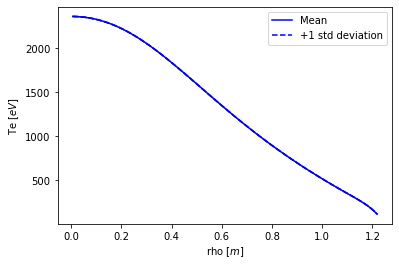

In [16]:
plot_te(analysis)

In [17]:
def plot_grid_2D():

    labels = list(my_campaign.get_active_sampler().vary.get_keys())
    values = list(my_campaign.get_active_sampler().vary.get_values())
    L = (len(labels)+1)//2
    C = int(np.ceil(np.sqrt((10+1)//2)))
    R = int(np.ceil(L / C))

    fig = plt.figure(figsize=[12,12/C*R])
    
    ax=[]
    ic=0
    for i in range(L-1):
        xd = values[ic*2].upper[0] - values[ic*2].lower[0]
        yd = values[ic*2+1].upper[0] - values[ic*2+1].lower[0]
        ax.append(fig.add_subplot(R, C, ic+1,
                                  xlim=[values[ic*2].lower[0] - xd/10, values[ic*2].upper[0] + xd/10],
                                  ylim=[values[ic*2+1].lower[0] - yd/10, values[ic*2+1].upper[0] + yd/10], 
                                  xlabel=labels[ic*2], ylabel=labels[ic*2+1])
                 )
        ic += 1

    xd = values[ic*2].upper[0] - values[ic*2].lower[0]
    yd = values[ic*2+1].upper[0] - values[ic*2+1].lower[0]
    ax.append(fig.add_subplot(R, C, ic+1,
                              xlim=[values[-2].lower[0] - xd/10, values[-2].upper[0] + xd/10], 
                              ylim=[values[-1].lower[0] - yd/10, values[-1].upper[0] + yd/10], 
                              xlabel=labels[-2], ylabel=labels[-1])
             )

    accepted_grid = sampler.generate_grid(analysis.l_norm)

    ic=0
    for i in range(L-1):
        ax[i].plot(accepted_grid[:,ic*2], accepted_grid[:,ic*2+1], 'o', alpha=0.25)
        ic += 1
    ax[-1].plot(accepted_grid[:,-2], accepted_grid[:,-1], 'o', alpha=0.25)
    
    plt.tight_layout()

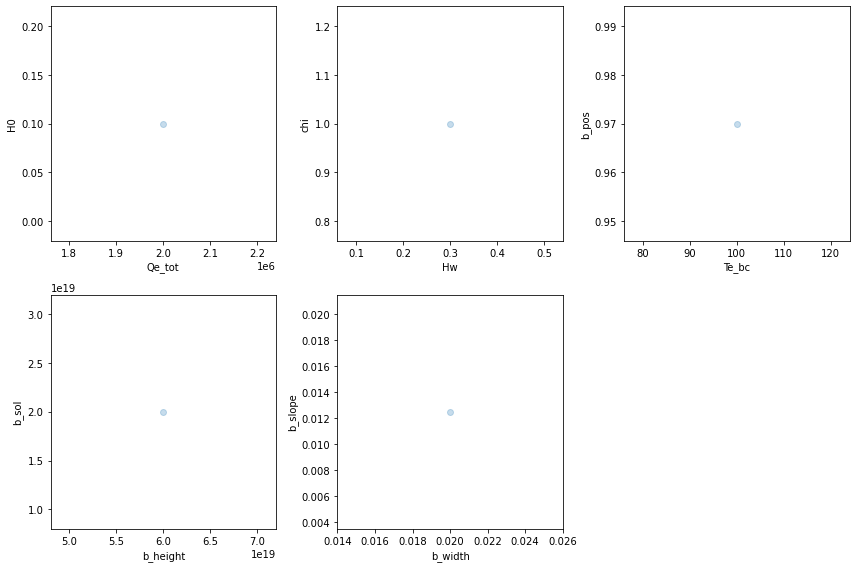

In [18]:
plot_grid_2D()

To refine the sampling plan, we need to:

* Compute the candidate directions of the admissible set. This is done in the `look_ahead` subroutine.
* Run the ensemble of the new points. This is done exactly the same as before.
* Accept the direction with the highest error. This is done in the `adapt_dimension` subroutine.

In [19]:
def refine_sampling_plan(number_of_refinements):
        """
        Refine the sampling plan.

        Parameters
        ----------
        number_of_refinements (int)
           The number of refinement iterations that must be performed.

        Returns
        -------
        None. The new accepted indices are stored in analysis.l_norm and the admissible indices
        in sampler.admissible_idx.
        """
        for i in range(number_of_refinements):
            # compute the admissible indices
            sampler.look_ahead(analysis.l_norm)

            # run the ensemble
            my_campaign.execute().collate(progress_bar=True)

            # accept one of the multi indices of the new admissible set
            data_frame = my_campaign.get_collation_result()
            analysis.adapt_dimension('te', data_frame)

Note that the subroutine above uses the surplus error by default. To select the variance-based error use `analysis.adapt_dimension('f', data_frame, method='var')` instead.

In [20]:
# refine the sampling plan once and then do the analysis to see the results.
refine_sampling_plan(1)
my_campaign.apply_analysis(analysis)

100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


In [21]:
frms_mean, frms = test_surrogate()
S.append([frms_mean, frms])

In [22]:
analysis.l_norm

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 2, 1, 1, 1, 1, 1, 1, 1]])

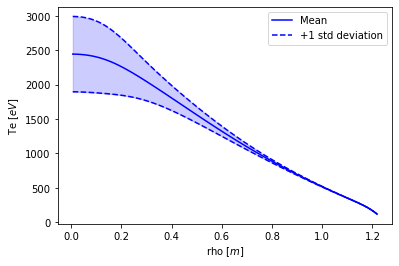

In [23]:
plot_te(analysis)

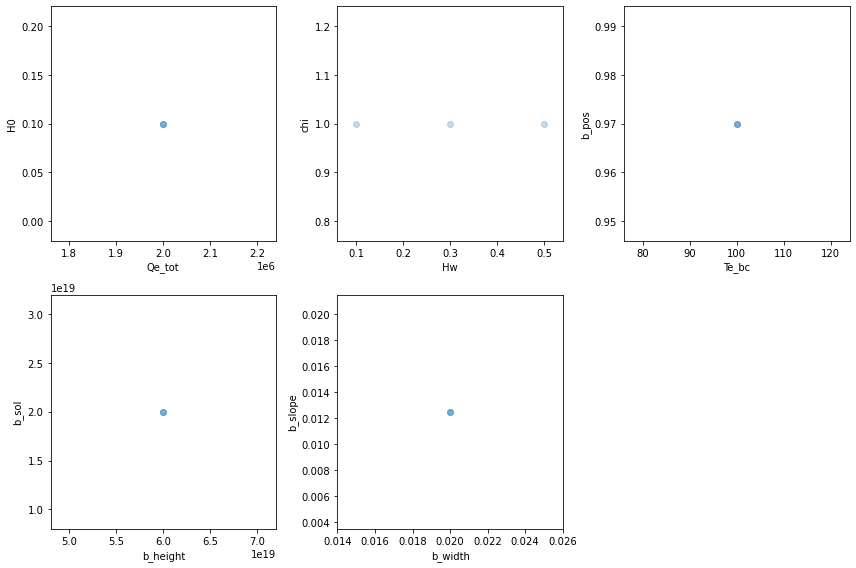

In [24]:
# plot the 2D slices again. Note that the most important input (Hw) got refined.
plot_grid_2D()

In [25]:
# repeat
refine_sampling_plan(1)
my_campaign.apply_analysis(analysis)

100%|██████████| 2/2 [00:00<00:00,  3.00it/s]


In [26]:
frms_mean, frms = test_surrogate()
S.append([frms_mean, frms])

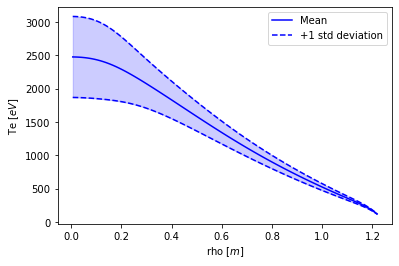

In [27]:
plot_te(analysis)

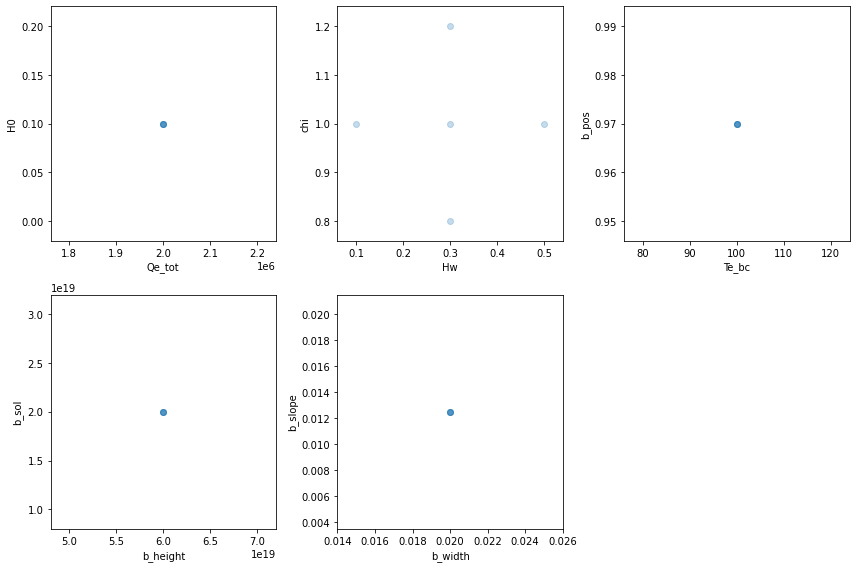

In [28]:
# Now chi got refined. 
plot_grid_2D()

In [29]:
# again
refine_sampling_plan(1)
my_campaign.apply_analysis(analysis)

100%|██████████| 6/6 [00:01<00:00,  5.94it/s]


In [30]:
frms_mean, frms = test_surrogate()
S.append([frms_mean, frms])

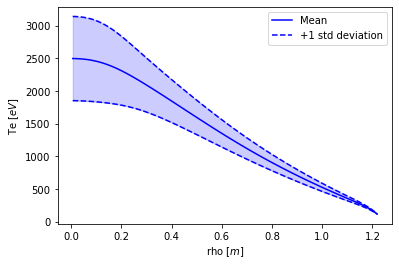

In [31]:
plot_te(analysis)

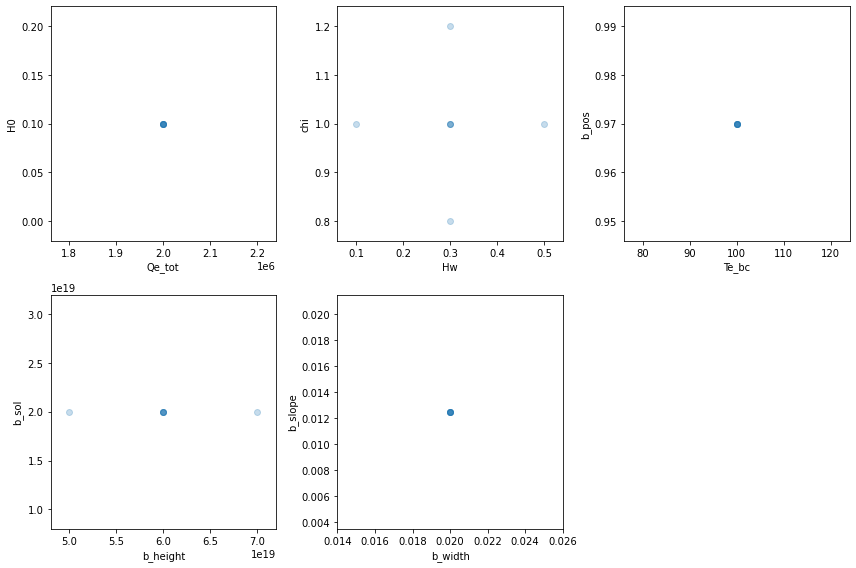

In [32]:
# now H0 got refined to first order
plot_grid_2D()

In [33]:
# perform 100 refinements
for i in range(100):
    print('%s/%s' % (i,100))
    refine_sampling_plan(1)
    my_campaign.apply_analysis(analysis)
    frms_mean, frms = test_surrogate()
    S.append([frms_mean, frms])

  0%|          | 0/10 [00:00<?, ?it/s]

0/100


100%|██████████| 10/10 [00:01<00:00,  8.10it/s]


1/100


100%|██████████| 14/14 [00:01<00:00,  9.05it/s]
0it [00:00, ?it/s]

2/100


3/100


100%|██████████| 18/18 [00:01<00:00,  9.85it/s]
0it [00:00, ?it/s]

4/100



0it [00:00, ?it/s]

5/100



0it [00:00, ?it/s]

6/100



  0%|          | 0/8 [00:00<?, ?it/s]

7/100


100%|██████████| 8/8 [00:01<00:00,  7.80it/s]


8/100


100%|██████████| 8/8 [00:01<00:00,  6.80it/s]
0it [00:00, ?it/s]

9/100


10/100


100%|██████████| 22/22 [00:02<00:00,  9.35it/s]


11/100


100%|██████████| 16/16 [00:01<00:00,  9.12it/s]
0it [00:00, ?it/s]

12/100


13/100


  0%|          | 0/8 [00:00<?, ?it/s]

14/100


100%|██████████| 8/8 [00:01<00:00,  7.42it/s]


15/100


100%|██████████| 20/20 [00:02<00:00,  9.00it/s]
0it [00:00, ?it/s]

16/100


17/100


  0%|          | 0/4 [00:00<?, ?it/s]

18/100


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]
0it [00:00, ?it/s]

19/100


20/100


100%|██████████| 24/24 [00:02<00:00, 10.71it/s]
0it [00:00, ?it/s]

21/100


22/100


100%|██████████| 30/30 [00:03<00:00,  9.75it/s]
0it [00:00, ?it/s]

23/100


24/100


100%|██████████| 34/34 [00:03<00:00,  9.56it/s]


25/100


100%|██████████| 38/38 [00:04<00:00,  9.00it/s]
0it [00:00, ?it/s]

26/100



0it [00:00, ?it/s]

27/100



  0%|          | 0/4 [00:00<?, ?it/s]

28/100


  0%|          | 0/4 [00:00<?, ?it/s]

29/100


100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


30/100


100%|██████████| 8/8 [00:01<00:00,  7.42it/s]


31/100


  0%|          | 0/8 [00:00<?, ?it/s]

32/100


100%|██████████| 8/8 [00:01<00:00,  7.20it/s]
0it [00:00, ?it/s]

33/100


34/100


100%|██████████| 16/16 [00:01<00:00,  9.32it/s]


35/100


100%|██████████| 16/16 [00:01<00:00,  9.67it/s]
0it [00:00, ?it/s]

36/100


37/100


0it [00:00, ?it/s]


38/100


100%|██████████| 8/8 [00:01<00:00,  7.25it/s]
0it [00:00, ?it/s]

39/100



0it [00:00, ?it/s]

40/100


41/100


100%|██████████| 16/16 [00:01<00:00,  9.62it/s]
0it [00:00, ?it/s]

42/100



0it [00:00, ?it/s]

43/100



0it [00:00, ?it/s]

44/100


45/100


100%|██████████| 16/16 [00:01<00:00,  9.59it/s]
0it [00:00, ?it/s]

46/100


47/100


100%|██████████| 28/28 [00:02<00:00,  9.70it/s]


48/100


100%|██████████| 16/16 [00:01<00:00,  9.62it/s]
0it [00:00, ?it/s]

49/100


50/100


100%|██████████| 8/8 [00:01<00:00,  7.43it/s]


51/100


100%|██████████| 36/36 [00:04<00:00,  8.46it/s]


52/100


100%|██████████| 24/24 [00:02<00:00,  9.37it/s]
0it [00:00, ?it/s]

53/100



0it [00:00, ?it/s]

54/100


55/100


100%|██████████| 32/32 [00:03<00:00,  9.84it/s]
0it [00:00, ?it/s]

56/100


57/100


100%|██████████| 16/16 [00:02<00:00,  7.28it/s]
0it [00:00, ?it/s]

58/100


59/100


100%|██████████| 36/36 [00:05<00:00,  6.96it/s]


60/100


100%|██████████| 32/32 [00:04<00:00,  7.59it/s]
0it [00:00, ?it/s]

61/100


62/100


100%|██████████| 40/40 [00:05<00:00,  6.87it/s]


63/100


100%|██████████| 40/40 [00:04<00:00,  8.73it/s]
0it [00:00, ?it/s]

64/100



0it [00:00, ?it/s]

65/100


66/100


100%|██████████| 8/8 [00:01<00:00,  7.23it/s]


67/100


100%|██████████| 24/24 [00:02<00:00, 10.02it/s]
0it [00:00, ?it/s]

68/100


69/100


100%|██████████| 28/28 [00:02<00:00,  9.40it/s]
0it [00:00, ?it/s]

70/100



0it [00:00, ?it/s]

71/100



0it [00:00, ?it/s]

72/100


73/100


100%|██████████| 16/16 [00:01<00:00,  9.36it/s]
0it [00:00, ?it/s]

74/100



0it [00:00, ?it/s]

75/100


76/100


100%|██████████| 40/40 [00:03<00:00, 10.49it/s]
0it [00:00, ?it/s]

77/100



0it [00:00, ?it/s]

78/100


79/100


100%|██████████| 44/44 [00:04<00:00,  9.79it/s]


80/100


100%|██████████| 16/16 [00:01<00:00,  8.24it/s]
0it [00:00, ?it/s]

81/100


82/100


100%|██████████| 16/16 [00:12<00:00,  1.24it/s]


83/100


100%|██████████| 48/48 [00:05<00:00,  8.17it/s]


84/100


100%|██████████| 4/4 [00:00<00:00,  4.66it/s]
0it [00:00, ?it/s]

85/100


86/100


100%|██████████| 16/16 [00:01<00:00,  9.62it/s]
0it [00:00, ?it/s]

87/100


88/100


100%|██████████| 16/16 [00:01<00:00,  9.95it/s]


89/100


100%|██████████| 56/56 [00:06<00:00,  8.66it/s]


90/100


100%|██████████| 16/16 [00:01<00:00,  9.70it/s]
0it [00:00, ?it/s]

91/100


92/100


100%|██████████| 16/16 [00:01<00:00, 10.32it/s]


93/100


100%|██████████| 32/32 [00:03<00:00, 10.60it/s]
0it [00:00, ?it/s]

94/100


95/100


100%|██████████| 44/44 [00:04<00:00,  9.20it/s]


96/100


100%|██████████| 16/16 [00:01<00:00,  9.97it/s]
0it [00:00, ?it/s]

97/100


98/100


100%|██████████| 52/52 [00:06<00:00,  8.32it/s]
0it [00:00, ?it/s]

99/100


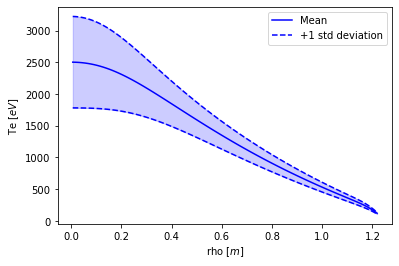

In [34]:
plot_te(analysis)

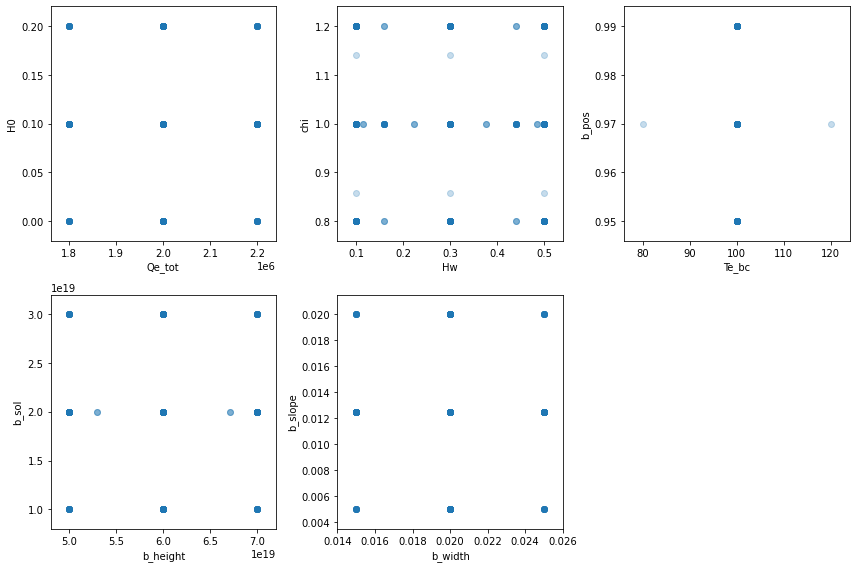

In [35]:
# Plot the slices again. 
plot_grid_2D()

### Post processing

There are a number of post-processing step we can take. Below we show the 'adaptation table' which displays which multi indices were refined at every iteration.

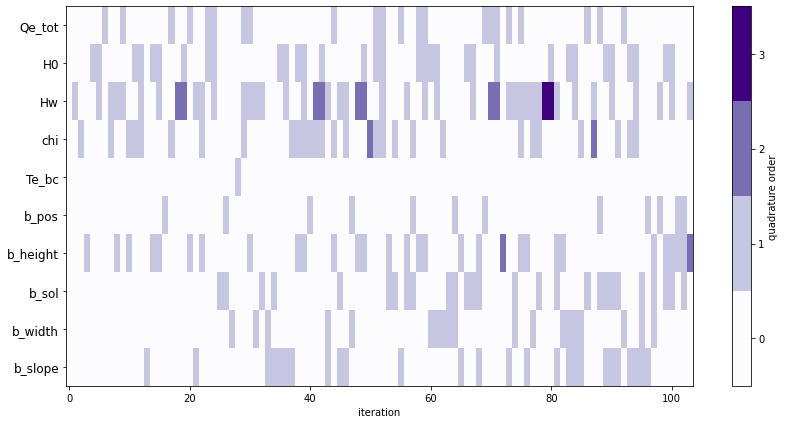

<Figure size 432x288 with 0 Axes>

In [36]:
analysis.adaptation_table()
plt.savefig('Adaptation_table_DASC.png')
plt.savefig('Adaptation_table_DASC.pdf')

In [37]:
analysis.adaptation_table?

We can also make a histogram which visualises the adaptation. This displays only a first-order information, i.e. only the maximum quadrature order per input. It therefore does not display that certain inputs were refined simultaneously:

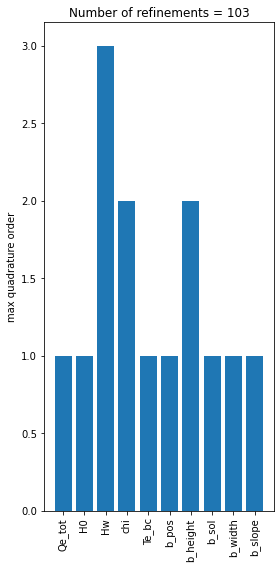

In [38]:
analysis.adaptation_histogram()

To get a list of the error magnitudes associated to the multi indices that were selected use:

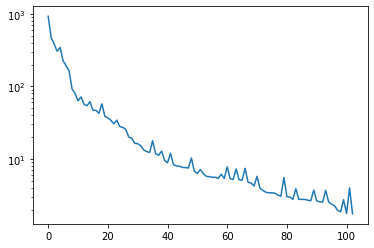

In [39]:
plt.semilogy(analysis.get_adaptation_errors())

This shows a nice decrease of the error.

To compute the mean and variance of the code output we use:

In [40]:
analysis.get_uncertainty_amplification('te')

0.8663242668726445

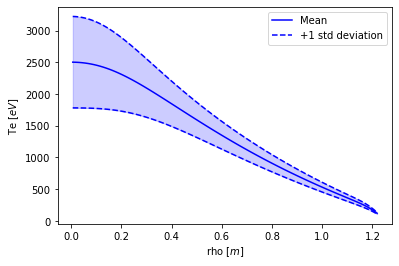

In [41]:
plot_te(analysis)

We can see that the estimates are fair, although not yet fully converged in this case. Note however that these results are computed only with the accepted set of multi indices. At the end, we can merge the accepted and admissible set (thereby using all samples), and recompute the results:

In [42]:
analysis.merge_accepted_and_admissible()
df = my_campaign.get_collation_result()
results = analysis.analyse(df)

In [43]:
frms_mean, frms = test_surrogate()
S.append([frms_mean, frms])

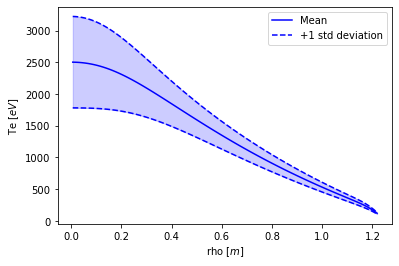

In [44]:
plot_te(analysis)

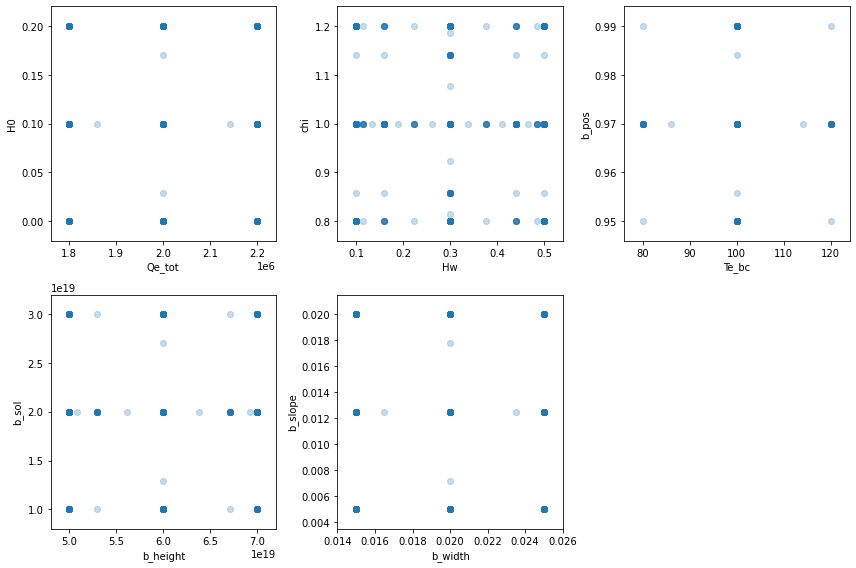

In [45]:
# Plot the slices again. 
plot_grid_2D()
plt.savefig('Grid_DASC.png')
plt.savefig('Grid_DASC.pdf')

This improved our estimates. Note however, that if we would refine again from this point, the new admissble set will be very large, since we added *all* previous admissible indices to the accepted set. This opens up a wide range of possible new candidate directions, making the corresponding ensemble very large.

Thus if we are still not happy about the result, we first have to undo the merging via `analysis.undo_merge()`, before refining again.

In [46]:
# This will undo the merge, and reproduce the old results
#analysis.undo_merge()
#df = campaign.get_collation_result()
#results = analysis.analyse(df)
#print('Mean = %.4e' % results.describe('f', 'mean'))
#print('Standard deviation = %.4e' % results.describe('f', 'std'))

We can also display the Sobol sensitivity indices via:

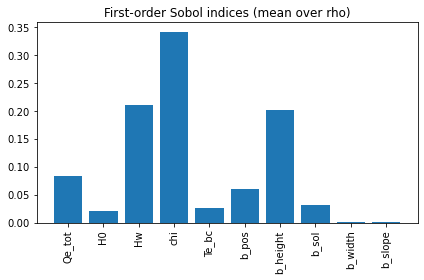

In [47]:
sobols = []
# retrieve the Sobol indices from the results object
params = list(sampler.vary.get_keys())
for param in params:
    sobols.append(results._get_sobols_first('te', param))
sobols = np.array(sobols).mean(axis=1)
# make a bar chart
fig = plt.figure()
ax = fig.add_subplot(111, title='First-order Sobol indices (mean over rho)')
ax.bar(range(len(sobols)), height=np.array(sobols).flatten())
ax.set_xticks(range(len(sobols)))
ax.set_xticklabels(params)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('Average_Sobol_DASC.png')
plt.savefig('Average_Sobol_DASC.pdf')

In [48]:
dict(zip(params, sobols))

{'Qe_tot': 0.0826519003066042,
 'H0': 0.01976287997465273,
 'Hw': 0.21007714324359764,
 'chi': 0.34090854895957406,
 'Te_bc': 0.02555370033111004,
 'b_pos': 0.0608031439755366,
 'b_height': 0.20208219034474545,
 'b_sol': 0.030533812380147896,
 'b_width': 0.0008424155090723398,
 'b_slope': 0.0017000632610264885}

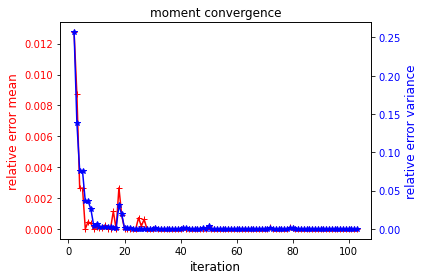

In [49]:
analysis.plot_stat_convergence()

In [50]:
te_mean, te_std = analysis.get_moments('te')[0], np.sqrt(analysis.get_moments('te')[1])
rho_mean, rho_std = analysis.get_moments('rho')[0], np.sqrt(analysis.get_moments('rho')[1])

rho_mean

array([0.00612372, 0.01837117, 0.03061862, 0.04286607, 0.05511352,
       0.06736097, 0.07960842, 0.09185587, 0.10410331, 0.11635076,
       0.12859821, 0.14084566, 0.15309311, 0.16534056, 0.17758801,
       0.18983546, 0.2020829 , 0.21433035, 0.2265778 , 0.23882525,
       0.2510727 , 0.26332015, 0.2755676 , 0.28781504, 0.30006249,
       0.31230994, 0.32455739, 0.33680484, 0.34905229, 0.36129974,
       0.37354719, 0.38579463, 0.39804208, 0.41028953, 0.42253698,
       0.43478443, 0.44703188, 0.45927933, 0.47152678, 0.48377422,
       0.49602167, 0.50826912, 0.52051657, 0.53276402, 0.54501147,
       0.55725892, 0.56950637, 0.58175381, 0.59400126, 0.60624871,
       0.61849616, 0.63074361, 0.64299106, 0.65523851, 0.66748595,
       0.6797334 , 0.69198085, 0.7042283 , 0.71647575, 0.7287232 ,
       0.74097065, 0.7532181 , 0.76546554, 0.77771299, 0.78996044,
       0.80220789, 0.81445534, 0.82670279, 0.83895024, 0.85119769,
       0.86344513, 0.87569258, 0.88794003, 0.90018748, 0.91243

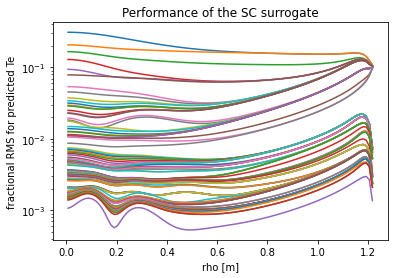

In [51]:
# plot the performance of the SC surrogates
if __name__ == '__main__':

    for i in range(len(S)):
        plt.semilogy(rho_mean, S[i][1])
    plt.xlabel('rho [m]') ; plt.ylabel('fractional RMS for predicted Te') #; plt.legend(loc=0, ncol=5)
    plt.title('Performance of the SC surrogate')
    plt.show()
#    plt.savefig('SC_surrogate.png')
#    plt.savefig('SC_surrogate.pdf')

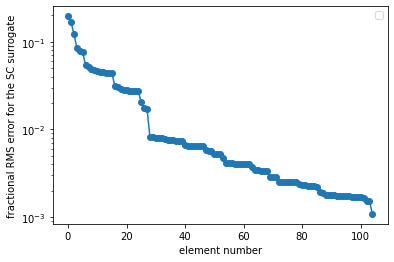

In [52]:
# plot the convergence of the surrogate based on 1000 random points
if __name__ == '__main__':
    plt.figure()
    plt.semilogy([s[0] for s in S], 'o-')
    plt.xlabel('element number')
    plt.ylabel('fractional RMS error for the SC surrogate')
    plt.legend(loc=0)
    plt.savefig('Convergence_DASC_surrogate.png')
    plt.savefig('Convergence_DASC_surrogate.pdf')